In [3]:
# general imports
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import wandb

In [4]:
# check successful setup
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))
import torchvision
print(torchvision.__version__)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr

2.5.1+cu124
NVIDIA GeForce RTX 4090
0.20.1+cu124


# RANS FFS

In [5]:
from upt.datasets.ffs_dataset import ffsDataset

num_test_inputs  = 4096
num_test_outputs = 4096
# num_train_inputs  = 8192
# num_train_outputs = 16000

num_train_inputs  = num_test_inputs 
num_train_outputs = num_test_outputs

crop_values= [[-3, -2], [3, 2]]

# initialize dataset
train_dataset = ffsDataset(
    root="./data/ffs/preprocessed",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_train_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_train_outputs,
    # mode
    mode="train",
    # crop
    crop_values= crop_values,
)

# test_dataset = ffsDataset(
#     root="./data/ffs/preprocessed",
#     # how many inputs to use for training
#     # num_inputs=float("inf"),
#     num_inputs=num_test_inputs,
#     # how many outputs to use for training
#     # num_outputs=float("inf"),
#     num_outputs=num_test_outputs,
#     # mode
#     mode="test",
#     # crop
#     crop_values= crop_values,
# )

In [6]:
# hyperparameters model
dim = 256
num_heads = 4
radius = 5
max_degree=32
depth=4
num_latent_tokens=512

# hyperparameters training
learning_rate = 1e-4
weight_decay=0.05
num_supernodes = 512
epochs = 1000
batch_size = 50


In [7]:
from upt.models.ffs_upt import ffsUPT
# from upt.models.upt import UPT
from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.conditioner_re import ConditionerRe

# initialize model
conditioner = ConditionerRe(
    dim=dim,
    num_values=train_dataset.num_values,
)
model = ffsUPT(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        # simulation has 1 input sdf
        input_dim=1,
        # 2D dataset
        ndim=2,
        # positions are rescaled to [0, 200]
        radius=radius,
        # in regions where there are a lot of mesh cells, it would result in supernodes having a lot of
        # connections to nodes. but since we sample the supernodes uniform, we also have a lot of supernodes
        # in dense regions, so we can simply limit the maximum amount of connections to each supernodes
        # to avoid an extreme amount of edges
        max_degree=max_degree,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=depth,
        # downsample to 128 latent tokens for fast training
        perc_dim=dim,
        perc_num_heads=num_heads,
        num_latent_tokens=num_latent_tokens,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 2D velocity + pressure
        output_dim=3,
        # simulation is 2D
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # we assume num_outputs to be constant so we can simply reshape the dense result into a sparse tensor
        unbatch_mode="dense_to_sparse_unpadded",
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

parameters: 34.9M


In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=False),
)
# test_dataloader = DataLoader(
#     dataset=test_dataset,
#     batch_size=batch_size,
#     collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=True),
# )

In [ ]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="battlejacket-liu",
    name="SDF_dummy_0",
    # Set the wandb project where this run will be logged.
    project="UPT-DO",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "dataset": "ffs",
        "epochs": epochs,
        "num_test_inputs": num_test_inputs,
        "num_test_outputs": num_test_outputs,
        "num_train_inputs": num_train_inputs,
        "num_train_outputs": num_train_outputs,
        "dim": dim,
        "num_heads": num_heads,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "num_supernodes": num_supernodes,
        "depth": depth,
        "encoder_radius": radius,
        "encoder_max_degree": max_degree,
        "encoder_num_latent_tokens": num_latent_tokens,
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: battlejacket (battlejacket-liu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
test_accuracy = 0.0
train_losses = []
test_losses = []
loss = None
test_loss = None
for _ in range(epochs):
    # train for an epoch
    for batch in train_dataloader:
        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            # input_feat=None,
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),

        )
        y = batch["target_feat"].to(device)
        assert y_hat.shape == y.shape
        loss = F.mse_loss(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        update += 1
        pbar.update()
        if test_loss is None:
            pbar.set_description(f"train_loss: {loss.item():.4f}")
        else:
            pbar.set_description(
                f"train_loss: {loss.item():.4f} "
                f"test_loss: {test_loss:.4f} "
            )
        train_losses.append(loss.item())

    # evaluate
    # test_loss = 0.
    # for batch in test_dataloader:
    #     with torch.no_grad():
    #         y_hat = model(
    #             input_feat=batch["input_feat"].to(device),
    #             # input_feat=None,
    #             input_pos=batch["input_pos"].to(device),
    #             supernode_idxs=batch["supernode_idxs"].to(device),
    #             batch_idx=batch["batch_idx"].to(device),
    #             output_pos=batch["output_pos"].to(device),
    #             re=batch["re"].to(device),
    #         )
    #     y = batch["target_feat"].to(device)
    #     test_loss += (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
    # test_loss /= len(test_dataloader)
    # test_losses.append(test_loss)
    pbar.set_description(
        f"train_loss: {loss.item():.4f} "
        # f"test_loss: {test_loss:.4f} "
    )
    wandb.log(
        {
            "train_loss": loss.item(),
            # "test_loss": test_loss,
            "learning_rate": optim.param_groups[0]["lr"],
        }
    )
pbar.close()

train_loss: 3.3988 :   0%|          | 2/2000 [00:19<5:16:52,  9.52s/it]


train_loss: 0.0400 : 100%|██████████| 2000/2000 [18:48<00:00,  1.77it/s]


In [23]:
torch.save(model.state_dict(), 'save/sdf_model.pth')
# wandb.save('save/sdf_model.pth')

In [8]:
model.load_state_dict(torch.load('save/sdf_model.pth', weights_only=True))
model.eval()

ffsUPT(
  (conditioner): ConditionerRe(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
    )
    (re_embed): ContinuousSincosEmbed(dim=256)
  )
  (encoder): EncoderSupernodes(
    (supernode_pooling): SupernodePooling(
      (input_proj): LinearProjection(
        (proj): Linear(in_features=1, out_features=256, bias=True)
      )
      (pos_embed): ContinuousSincosEmbed(dim=256)
      (message): Sequential(
        (0): LinearProjection(
          (proj): Linear(in_features=512, out_features=256, bias=True)
        )
        (1): GELU(approximate='none')
        (2): LinearProjection(
          (proj): Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (enc_proj): LinearProjection(
      (proj): Identity()
    )
    (blocks): Sequential(
      (0): DitBlock(
        (modulation): Dit(
          (modulation): Linear(in_features=1024, out_features=1536, bias=True)
        )
        (norm1): LayerNorm

In [16]:
test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=40000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=40000,
    # mode
    mode="train",
    crop_values=crop_values,
)

In [17]:
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
torch.cuda.empty_cache()
testvis_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=2048, deterministic=True),
)
vis_batch = next(iter(testvis_dataloader))

# make predictions
with torch.no_grad():
    y_hat = model(
        input_feat=vis_batch["input_feat"].to(device),
        input_pos=vis_batch["input_pos"].to(device),
        supernode_idxs=vis_batch["supernode_idxs"].to(device),
        batch_idx=vis_batch["batch_idx"].to(device),
        output_pos=vis_batch["output_pos"].to(device),
        re=vis_batch["re"].to(device),
    )

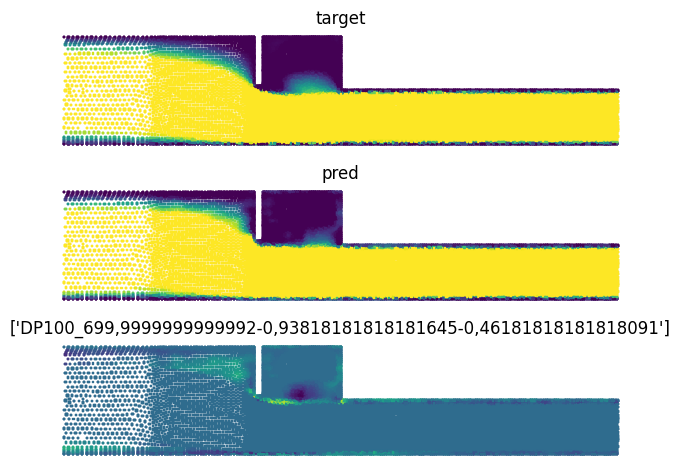

In [18]:
# plot sparse
# x_pos, y_pos = test_dataset.denormalize_pos(vis_batch["output_pos"][0]).unbind(1)
x_pos, y_pos = test_hr_dataset.denormalize_pos(vis_batch["output_pos"][0]).unbind(1)
pred = test_hr_dataset.denormalize_feat(y_hat.cpu()).clamp(0, 1)
target = test_hr_dataset.denormalize_feat(vis_batch["target_feat"]).clamp(0, 1)
pred = pred[:,0]
target = target[:,0]

_, axes = plt.subplots(3, 1) #, figsize=(10, 2)
axes[0].scatter(x_pos, y_pos, c=target, marker="s", s=1)
axes[0].set_title("target")
axes[0].set_axis_off()
axes[1].scatter(x_pos, y_pos, c=pred, marker="s", s=1)
axes[1].set_title("pred")
axes[1].set_axis_off()
axes[2].scatter(x_pos, y_pos, c=pred-target, marker="s", s=1)
axes[2].set_title("diff")
axes[2].set_axis_off()
plt.tight_layout()
plt.title(vis_batch["name"])
plt.show()